In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import matplotlib.pyplot as plt
import pyextremes as pyx

In [5]:
def hill_estimator(data, k):
    log_data = np.log(data[:k])
    return (1/k) * np.sum(log_data) - np.log(data[k])

def pickands_estimator(data, k):
    if 4*k >= len(data):
        return np.nan
    return 1/np.log(2) * np.log((data[k] - data[2*k])/(data[2*k] - data[4*k]))

def threshold_picking(data0):
    data = -data0[data0 < 0]
    thresholds = np.linspace(data.quantile(0.2), data.quantile(0.995), 200)
    pyx.plot_mean_residual_life(data, thresholds=thresholds)
    datas = np.sort(data)[::-1]
    k_values = range(4, int(len(datas)/1.3))

    hill_estimates = [hill_estimator(datas, k) for k in k_values]
    plt.figure(figsize=(10,6))
    plt.plot(k_values, hill_estimates, 'b-')

    pickands_estimates = [pickands_estimator(datas, k) for k in k_values]
    plt.figure(figsize=(10,6))
    plt.plot(k_values, pickands_estimates, 'r-', label="Pickands' ξ")
    return datas

def modeling(data0, u):
    data = -data0[data0 < 0]
    model = pyx.EVA(data)
    model.get_extremes(method="POT", threshold=u)
    model.fit_model(distribution="genpareto")
    print(model.model)
    model.plot_diagnostic()

    params = model.model.fit_parameters
    print(params)
    xi = params['c']
    sig = params['scale']
    return xi, sig

def prediction(params, data, u, level):
    xi = params[0]
    sig = params[1]
    data = -data
    p = level
    n_total = len(data)
    n_exceed = len([i for i in data if i > u])
    F_u = n_exceed / n_total
    print(F_u)
    p_u = F_u / p
    VaR = u + (sig / xi) * (p_u ** xi - 1)
    ES = ES = (VaR + (sig - xi * u)) / (1 - xi)
    return VaR, ES

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

doge_data = pd.read_csv("../data/doge_daily_data.csv")
doge_data.set_index("Date", inplace=True)
returns = np.log(doge_data / doge_data.shift(1)).dropna()
returns = returns['Price']
returns.index = pd.to_datetime(returns.index)

# Create volatility proxy (squared returns)
volatility = returns ** 2

#Create volatility proxy (garch fitted)
#from arch import arch_model
#garch = arch_model(returns['^GSPC'], vol="GARCH", p=1, q=1)
#garch_fit = garch.fit(update_freq=5)
#volatility = garch_fit.conditional_volatility


# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_vol = scaler.fit_transform(volatility.values.reshape(-1, 1))

# Split data 50:50
split_idx = len(scaled_vol) // 2
train_vol, test_vol = scaled_vol[:split_idx], scaled_vol[split_idx:]
train_returns, test_returns = returns[:split_idx], returns[split_idx:]

In [8]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20  # Lookback window
X_train, y_train = create_sequences(train_vol, seq_length)
X_test, y_test = create_sequences(test_vol, seq_length)

In [9]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(32, activation='tanh'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

# Train with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/100


c:\Users\natha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 8.6088e-05 - mae: 0.0051 - val_loss: 5.4549e-04 - val_mae: 0.0031
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1247e-05 - mae: 0.0035 - val_loss: 5.4532e-04 - val_mae: 0.0037
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.8931e-05 - mae: 0.0033 - val_loss: 5.4558e-04 - val_mae: 0.0040
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.0766e-05 - mae: 0.0034 - val_loss: 5.4380e-04 - val_mae: 0.0036
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.9145e-05 - mae: 0.0032 - val_loss: 5.4310e-04 - val_mae: 0.0027
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.8512e-05 - mae: 0.0033 - val_loss: 5.4353e-04 - val_mae: 0.0024
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8091e-05 - mae: 0.0031 - val_loss: 5.4425e-04 - val_mae: 0.0022
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.7945e-05 - mae: 0.0032 - val_loss: 5.4539e-04 - val_mae: 0.0020
Epoc

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
(2073,)
              MLE model              
-------------------------------------
free parameters: c=0.219, scale=8.760
fixed parameters: floc=18.738        
AIC: 654.829                         
loglikelihood: -325.350              
return value cache size: 0           
fit parameter cache size: 0          
-------------------------------------
{'c': 0.21880754533917388, 'scale': 8.760461997486473}
0.05065123010130246
35.80040059779785
[-0.1284943  -0.12728974 -0.12586096 ... -0.13130243 -0.12954827
 -0.12762333]
Date
2019-09-12    0.010780
2019-09-13    0.000412
2019-09-14    0.006164
2019-09-15    0.007754
2019-09-16   -0.002035
                ...   
2025-05-31   -0.004440
2025-06-01    0.005453
2025-06-02    0.009038
2025-06-03   -0.011593
2025-06-04   -0.009172
Name: Price, Length: 2093, dtype: float64


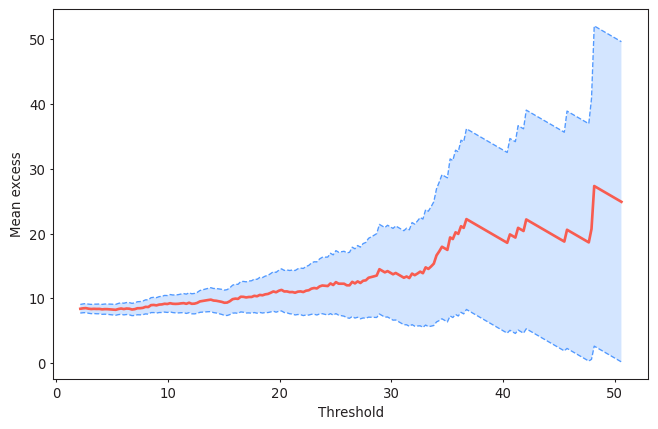

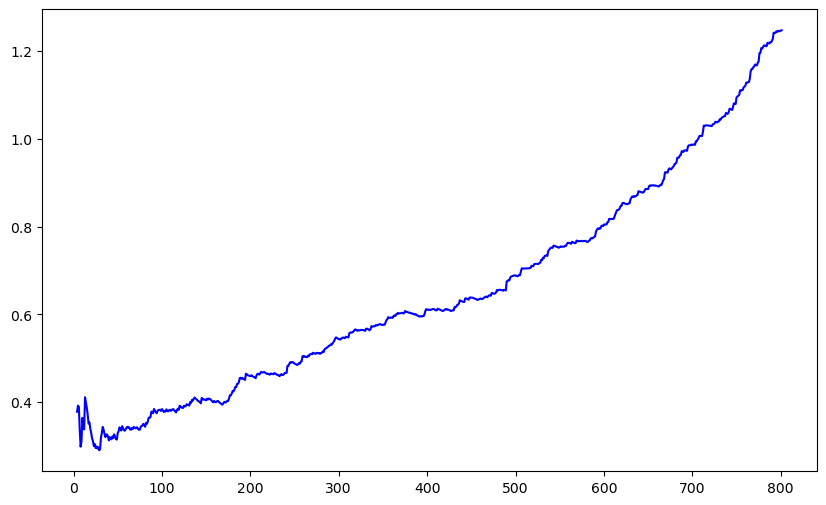

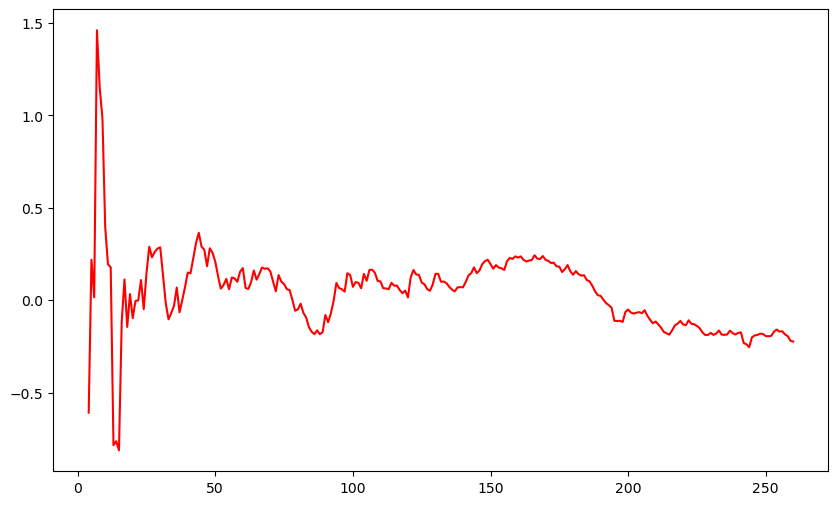

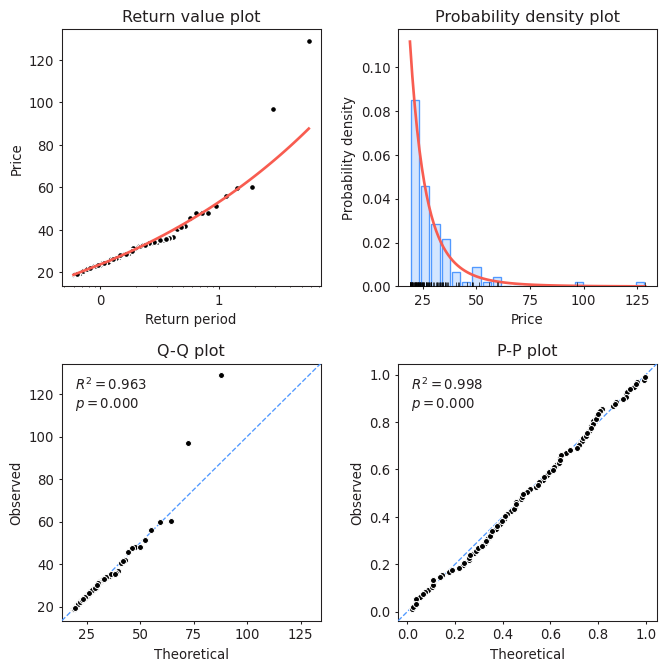

In [ ]:
volatility_forecasts = model.predict(X_test)
volatility_forecasts = scaler.inverse_transform(volatility_forecasts)


volatility_forecasts = volatility_forecasts.squeeze()
#print(volatility_forecasts.shape)
residuals = test_returns[20:] / volatility_forecasts
#print(residuals.shape)

sorted_ml_sp500 = threshold_picking(residuals)
VaR_quantile = sorted_ml_sp500[105]
params = modeling(residuals, VaR_quantile)
VaR_ml, ES_ml = prediction(params, residuals, VaR_quantile, level=0.01)

print(VaR_ml)

VaR_forecast = volatility_forecasts * -VaR_ml
print(VaR_forecast)
print(test_returns)

# Align returns with predictions (assuming seq_length was used in training)
#returns_aligned = test_returns[seq_length:]

In [13]:
from scipy.stats import chi2

def conditional_coverage_test(actual_returns, var_forecast, alpha=0.05):
    # Unconditional Coverage (UC) Test
    actual_returns = np.asarray(actual_returns).flatten()
    var_forecast = np.asarray(var_forecast).flatten()
    
    min_length = min(len(actual_returns), len(var_forecast))
    actual_returns = actual_returns[:min_length]
    var_forecast = var_forecast[:min_length]

    violations = (actual_returns < var_forecast).astype(int) 
    #print(violations.head())
    n = len(violations)
    V = np.sum(violations)
    p_uc = V / n
    #print(actual_returns.head(), var_forecast, p_uc)
    LR_uc = -2 * np.log((alpha**V * (1 - alpha)**(n - V))) + 2 * np.log((p_uc**V * (1 - p_uc)**(n - V)))
    p_value_uc = 1 - chi2.cdf(LR_uc, df=1)
    
    # Independence (IND) Test
    # Count transitions: n_ij = transitions from state i to j (0=no violation, 1=violation)
    n00, n01, n10, n11 = 0, 0, 0, 0
    for t in range(1, n):
        prev, curr = violations[t-1], violations[t]
        if prev == 0 and curr == 0: n00 += 1
        elif prev == 0 and curr == 1: n01 += 1
        elif prev == 1 and curr == 0: n10 += 1
        elif prev == 1 and curr == 1: n11 += 1
    
    # Transition probabilities under H0 (independence)
    p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    p11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    p_ind = (n01 + n11) / (n00 + n01 + n10 + n11)  # Marginal violation probability
    
    # Likelihoods
    L_ind = (1 - p_ind)**(n00 + n10) * p_ind**(n01 + n11)  # Independence
    L_actual = (1 - p01)**n00 * p01**n01 * (1 - p11)**n10 * p11**n11  # Observed
    
    LR_ind = -2 * np.log(L_ind / L_actual) if L_actual > 0 else 0
    p_value_ind = 1 - chi2.cdf(LR_ind, df=1)
    
    # Conditional Coverage (CC) Test
    LR_cc = LR_uc + LR_ind
    p_value_cc = 1 - chi2.cdf(LR_cc, df=2)
    
    # Decisions
    reject_uc = p_value_uc < 0.05
    reject_ind = p_value_ind < 0.05
    reject_cc = p_value_cc < 0.05
    
    return {
        "LR_UC": LR_uc,
        "p-value_UC": p_value_uc,
        "Reject_UC?": reject_uc,
        "LR_IND": LR_ind,
        "p-value_IND": p_value_ind,
        "Reject_IND?": reject_ind,
        "LR_CC": LR_cc,
        "p-value_CC": p_value_cc,
        "Reject_CC?": reject_cc,
        "Violation Rate": V / n,
        "Expected Rate": alpha,
        "Transition Matrix": [[n00, n01], [n10, n11]],
    }

conditional_coverage_test(test_returns, VaR_forecast, alpha=0.01)

{'LR_UC': 0.8335853489103897,
 'p-value_UC': 0.3612378326672905,
 'Reject_UC?': False,
 'LR_IND': 1.0404294167664974,
 'p-value_IND': 0.3077216219663964,
 'Reject_IND?': False,
 'LR_CC': 1.874014765676887,
 'p-value_CC': 0.3917985858526609,
 'Reject_CC?': False,
 'Violation Rate': 0.0120598166907863,
 'Expected Rate': 0.01,
 'Transition Matrix': [[2023, 24], [24, 1]]}